# Tutorial: Sentiment Analysis with LASER Embeddings and RNN

In this tutorial, we will guide you through the process of installing the necessary libraries, downloading a sentiment analysis dataset, and building a sentiment analysis model using [LASER](https://github.com/facebookresearch/LASER) embeddings and a Recurrent Neural Network (RNN).



## Step 1: Installing Laser Encoder

To begin, let's install the laser_encoders library along with its dependencies. These include sacremoses, sentencepiece, and fairseq. You can achieve this by running the following command:

In [1]:
! pip install laser_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 895.1/895.1 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.6/9.6 MB 46.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.4/106.4 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.9/279.9 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 17.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fairseq: filename=fairseq-0.12.2-cp310-cp310-linux_x86_64.whl size=11291810 sha256=b3ff4cd627ac15739369c768af1fa74a1c911e60d10bc09570d8c04384072df5

This ensures that you have all the required packages for this tutorial.

## Step 2: Install Additional Libraries

Before we proceed, let's install the chardet library, which is handy for detecting the encoding of the dataset.

In [2]:
!pip install chardet
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00


## Step 3: Import Necessary Libraries

Now, let's import the libraries required for data manipulation, encoding, and model building.

In [15]:
import numpy as np
import pandas as pd
import chardet
import matplotlib.pyplot as plt
from laser_encoders import LaserEncoderPipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tqdm import tqdm
from datasets import load_dataset
from collections import Counter

These libraries will be crucial for various stages of the tutorial.

## Step 4: Load the Dataset


The provided code loads a Twitter sentiment analysis dataset named "carblacac/twitter-sentiment-analysis" using the Hugging Face datasets library.
You can explore the dataset at [Twitter sentiment analysis](https://huggingface.co/datasets/carblacac/twitter-sentiment-analysis).

In [6]:
dataset_name = "carblacac/twitter-sentiment-analysis"

# Load the dataset using the dataset name
custom_dataset = load_dataset(dataset_name)

# Convert the dataset to a Pandas DataFrame
data = pd.DataFrame(custom_dataset['train'])

## Step 5: Data Processing

Before diving into model training, let's shuffle the dataset for better generalization:

In [7]:
data = data.sample(frac=1)
print(data.head())
print(data.shape)

                                                     text  feeling
49265   @dink76 I know I wish I had gone too. Hopefull...        1
114648  @emily_c getting knocked up will do that to yo...        0
87711   @rlanthony hell, I am awake and have things to...        0
38042   @danslamer  boy problems? I saw matt taylor at...        0
57981   @lady_karelia  Sem:  Just about. You can't get...        1
(119988, 2)


Shuffling helps prevent any potential biases in the data.



## Step 6:Visualizing Sentiment Distribution in the Dataset

This step involves creating a bar plot to visualize the distribution of sentiments in the dataset.

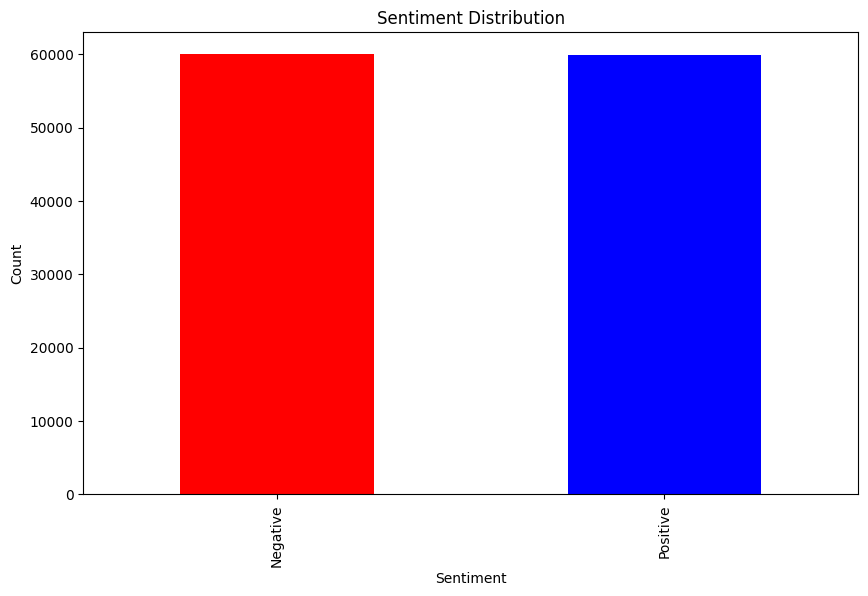

In [9]:
plt.figure(figsize=(10, 6))
ax = data['feeling'].value_counts().plot(kind='bar', color=['red', 'blue'])
ax.set_title('Sentiment Distribution')
ax.set_xlabel('Sentiment')
ax.set_ylabel('Count')

labels = ['Negative', 'Positive']
ax.set_xticks([0, 1])
ax.set_xticklabels(labels)

plt.show()

## Step 7: Extract Sentiments and Texts from DataFrame

Now, we'll extract sentiments and texts from the DataFrame.

In [11]:
sentiments = []
texts = []

for index, row in data.iterrows():
  sentiment = row['feeling']
  sentiments.append(sentiment)

  text = row['text'].lower()
  texts.append(text)

print(len(sentiments))
print(len(texts))

119988
119988


This step prepares the data by converting sentiments and texts into a suitable format for training.



## Step 8: Split the Dataset

For model training and evaluation, we'll split the dataset into training and validation sets:

In [19]:
label_encoder = LabelEncoder()
encoded_sentiments = label_encoder.fit_transform(sentiments)

# Split into training and temporary sets with stratification
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(
    texts, encoded_sentiments,
    test_size=0.2,
    random_state=42,
    stratify=encoded_sentiments
)

# Split the temporary set into the final training and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.2,
    random_state=42,
    stratify=y_temp
)

counter_train = Counter(y_train)
counter_test = Counter(y_test)

print("Training set - Class distribution:")
print("Class 0:", counter_train[0])
print("Class 1:", counter_train[1])

print("\nTest set - Class distribution:")
print("Class 0:", counter_test[0])
print("Class 1:", counter_test[1])


# Initialize the LaserEncoder
encoder = LaserEncoderPipeline(lang="eng_Latn")

Training set - Class distribution:
Class 0: 9595
Class 1: 9603

Test set - Class distribution:
Class 0: 2399
Class 1: 2401


A good practice is to reserve a portion of the data for validation to assess the model's performance.

## Step 9: LASER Embeddings

Now, let's leverage LASER embeddings to convert the text data into numerical representations:

In [20]:
# Initialize empty arrays to store embeddings
X_train_embeddings = []
X_test_embeddings = []

# Encode sentences line-wise using tqdm for progress visualization
print("Encoding training sentences:")
for sentence in tqdm(X_train):
    embeddings = encoder.encode_sentences([sentence])[0]
    X_train_embeddings.append(embeddings)

print("Encoding testing sentences:")
for sentence in tqdm(X_test):
    embeddings = encoder.encode_sentences([sentence])[0]
    X_test_embeddings.append(embeddings)

# Convert lists to numpy arrays
X_train_embeddings = np.array(X_train_embeddings)
X_test_embeddings = np.array(X_test_embeddings)

Encoding training sentences:


100%|██████████| 19198/19198 [02:23<00:00, 133.89it/s]


Encoding testing sentences:


100%|██████████| 4800/4800 [00:34<00:00, 137.51it/s]


## Step 10: Build and Train the RNN Model

With the data ready, it's time to build and train our sentiment analysis model using a simple RNN architecture:

In [21]:
# Sentiment Prediction with RNN Neural Network and Confusion Matrix

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Reshape, Dropout
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Build a neural network model with RNN
model = Sequential()
model.add(Dense(256, input_shape=(1024,), activation='tanh'))
model.add(Reshape((1, 256)))
model.add(SimpleRNN(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  # Adding dropout for regularization
model.add(Dense(2, activation='softmax'))

# Use a learning rate scheduler
def lr_schedule(epoch):
    return 0.0001 * 0.9 ** epoch

opt = Adam(learning_rate=0.0001)
lr_scheduler = LearningRateScheduler(lr_schedule)
#
# Compile the model
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Print model summary to check the architecture
model.summary()

# Train the model with the learning rate scheduler
model.fit(X_train_embeddings, y_train, epochs=30, batch_size=32, validation_split=0.1, callbacks=[lr_scheduler])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               262400    
                                                                 
 reshape (Reshape)           (None, 1, 256)            0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 128)               49280     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 320066 (1.22 MB)
Trainable params: 320066 

In this architecture, we employ a feedforward neural network with three dense layers, culminating in a softmax activation layer for sentiment classification.

## Step 11: Evaluate the Model
Finally, let's evaluate the model's performance on the validation set and calculate the accuracy:

In [22]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report

# Evaluate the model on the test set
accuracy = model.evaluate(X_test_embeddings, y_test)[1]
print(f"Accuracy: {accuracy * 100:.2f}%")

# Predictions on the test set
y_pred_probabilities = model.predict(X_test_embeddings)
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Calculate precision and recall per label
precision_per_label = precision_score(y_test, y_pred, average=None)
recall_per_label = recall_score(y_test, y_pred, average=None)

# Display precision and recall per label
for label, precision, recall in zip(range(len(precision_per_label)), precision_per_label, recall_per_label):
    print(f"Label {label}: Precision = {precision:.2f}, Recall = {recall:.2f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

150/150 [==============================] - 0s 3ms/step - loss: 0.4755 - accuracy: 0.7740
Accuracy: 77.40%
150/150 [==============================] - 0s 2ms/step
Label 0: Precision = 0.77, Recall = 0.79
Label 1: Precision = 0.78, Recall = 0.76

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.79      0.78      2399
           1       0.78      0.76      0.77      2401

    accuracy                           0.77      4800
   macro avg       0.77      0.77      0.77      4800
weighted avg       0.77      0.77      0.77      4800



This step provides insights into how well the model generalizes to new, unseen data.

## Step 12:Evaluate with Confusion Matrix

This matrix provides detailed insights into the model's predictions, showcasing true positives, true negatives, false positives, and false negatives.

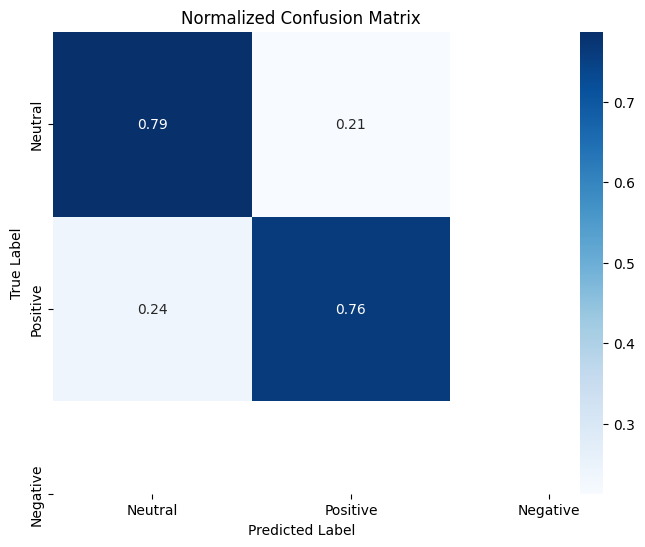

In [23]:
cm = confusion_matrix(y_test, y_pred)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, cmap='Blues', xticklabels=['Neutral', 'Positive', 'Negative'], yticklabels=['Neutral', 'Positive', 'Negative'])
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

## Step 13:Sentiment Prediction for User Input in Different Languages

In [24]:
language = input("Enter the language: ")
encoder = LaserEncoderPipeline(lang=language)


# Now, you can use the trained model to predict the sentiment of user input
user_text = input("Enter a text: ")
user_text_embedding = encoder.encode_sentences([user_text])[0]
user_text_embedding = np.reshape(user_text_embedding, (1, -1))

predicted_sentiment = np.argmax(model.predict(user_text_embedding))
predicted_sentiment_no = label_encoder.inverse_transform([predicted_sentiment])[0]
if predicted_sentiment_no == 0:
  predicted_sentiment_label = 'negative'
elif predicted_sentiment_no == 1:
  predicted_sentiment_label = 'positive'

print(f"Predicted Sentiment: {predicted_sentiment_label}")

Enter the language: english
Enter a text: hello how are you
1/1 [==============================] - 0s 147ms/step
Predicted Sentiment: positive


## Step 14:Sentiment Prediction for Multilingual Texts

This step involves iterating through a collection of sentiments expressed in various languages, including English, Hindi, Portuguese, Romanian, Slovenian, Chinese, French, Dutch, Russian, Italian, and Bosnian.

This process demonstrates the model's ability to analyze sentiments across diverse linguistic contexts and still yeild same output.

In [25]:
sentiments = {
    "english": "Said something harsh and didn't even realize it's harsh until I said it.. Sorry",
    'hindi': "कुछ कड़ाई बातें कहीं और मैंने यह तक महसूस नहीं किया कि यह कड़ाई है जब तक मैंने यह कहा.. माफ़ करें",
    'portuguese': "Disse algo duro e nem percebi que era duro até dizer.. Desculpe",
    'romanian': "Am spus ceva dur și nici măcar nu mi-am dat seama că e dur până când am spus asta.. Scuze",
    'slovenian': "Rekel sem nekaj ostrega in sploh nisem ugotovil, da je ostro, dokler nisem rekel.. Oprosti",
    'chinese': "说了一些刻薄的话，甚至直到我说出来我才意识到它很刻薄.. 抱歉",
    'french': "Ai dit quelque chose de dur et je n'ai même pas réalisé que c'était dur jusqu'à ce que je le dise.. Désolé",
    'dutch': "Iets hards gezegd en realiseerde me niet eens dat het hard was tot ik het zei.. Sorry",
    'russian': "Сказал что-то резкое и даже не осознал, насколько это резкое, пока не сказал.. Извините",
    'italian': "Ho detto qualcosa di duro e non me ne sono nemmeno reso conto finché non l'ho detto.. Scusa",
    'bosnian': "Rekao nešto oštro i čak nisam shvatio da je oštro dok nisam rekao.. Žao mi je"
}

# Iterate through the dictionary and extract values
for language, sentiment in sentiments.items():
  print(f"{language.capitalize()}: {sentiment}")
  encoder = LaserEncoderPipeline(lang=language)
  # Now, you can use the trained model to predict the sentiment of user input
  user_text = sentiment
  user_text_embedding = encoder.encode_sentences([user_text])[0]
  user_text_embedding = np.reshape(user_text_embedding, (1, -1))

  predicted_sentiment = np.argmax(model.predict(user_text_embedding))
  predicted_sentiment_no = label_encoder.inverse_transform([predicted_sentiment])[0]
  if predicted_sentiment_no == 0:
    predicted_sentiment_label = 'negative'
  elif predicted_sentiment_no == 1:
    predicted_sentiment_label = 'positive'

  print(f"Predicted Sentiment: {predicted_sentiment_label}")

English: Said something harsh and didn't even realize it's harsh until I said it.. Sorry
1/1 [==============================] - 0s 19ms/step
Predicted Sentiment: negative
Hindi: कुछ कड़ाई बातें कहीं और मैंने यह तक महसूस नहीं किया कि यह कड़ाई है जब तक मैंने यह कहा.. माफ़ करें


100%|██████████| 608M/608M [00:12<00:00, 48.9MB/s]


1/1 [==============================] - 0s 32ms/step


/usr/local/lib/python3.10/dist-packages/fairseq/models/transformer/transformer_encoder.py:281: UserWarning: The PyTorch API of nested tensors is in prototype stage and will change in the near future. (Triggered internally at ../aten/src/ATen/NestedTensorImpl.cpp:178.)
  x = torch._nested_tensor_from_mask(


Predicted Sentiment: negative
Portuguese: Disse algo duro e nem percebi que era duro até dizer.. Desculpe
1/1 [==============================] - 0s 30ms/step
Predicted Sentiment: negative
Romanian: Am spus ceva dur și nici măcar nu mi-am dat seama că e dur până când am spus asta.. Scuze
1/1 [==============================] - 0s 22ms/step
Predicted Sentiment: negative
Slovenian: Rekel sem nekaj ostrega in sploh nisem ugotovil, da je ostro, dokler nisem rekel.. Oprosti
1/1 [==============================] - 0s 20ms/step
Predicted Sentiment: negative
Chinese: 说了一些刻薄的话，甚至直到我说出来我才意识到它很刻薄.. 抱歉
1/1 [==============================] - 0s 26ms/step
Predicted Sentiment: negative
French: Ai dit quelque chose de dur et je n'ai même pas réalisé que c'était dur jusqu'à ce que je le dise.. Désolé
1/1 [==============================] - 0s 21ms/step
Predicted Sentiment: negative
Dutch: Iets hards gezegd en realiseerde me niet eens dat het hard was tot ik het zei.. Sorry
1/1 [============================

Congratulations! You have completed the sentiment analysis tutorial using LASER embeddings and an RNN. Feel free to experiment with different architectures, hyperparameters, or datasets to further improve the model.